In [1]:
import sys
sys.path.append("../src")

import logging
from pathlib import Path
import numpy as np
import torch
from natsort import natsorted
from torch import nn
from matplotlib import pyplot as plt
from dataset.data_loading import BasicDataset
from dataset.dataset_interface import DatasetInterface
from networks.UNet.unet_model import UNet
import open3d as o3d
from utils.visualization_utils import visualize_depth, to_rgb
from utils.transformation_utils import imgs_to_pcd, rs_ci, unnormalize_depth
import yaml

root_path = Path("../")

dataset_path = root_path / Path("resources/images/calibrated_masked_rg_cleaned2")
logging.info(f"using dataset {dataset_path}")
files = DatasetInterface.get_files_by_path(dataset_path)

INFO - 2022-02-26 12:05:53,155 - 656501530 - using dataset ../resources/images/calibrated_masked_rg_cleaned2


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2022-02-26 12:05:53,329 - 2295957556 - counted outliers 3216
INFO - 2022-02-26 12:05:53,369 - 2295957556 - Mean depth Input 865.9339599609375
INFO - 2022-02-26 12:05:53,369 - 2295957556 - Mean Distance IT 4.785691269348394
INFO - 2022-02-26 12:05:53,370 - 2295957556 - Max Distance IT 54.8466796875


[Open3D WARNING] GLFW Error: X11: Failed to convert selection to string


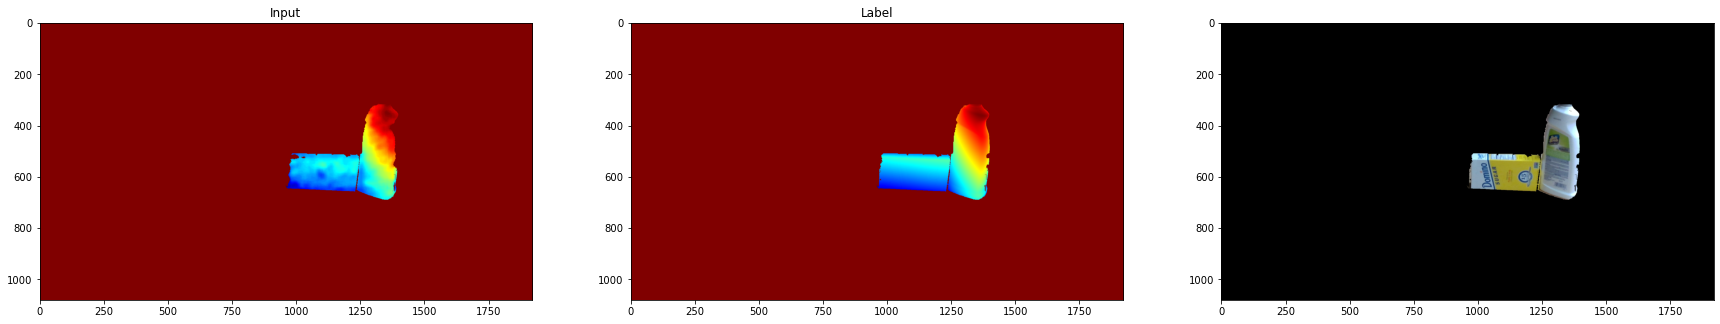

In [2]:
idx = np.random.randint(len(files), size=1).item()
rs_rgb, rs_depth, zv_rgb, zv_depth, mask = DatasetInterface.load(files[idx])

input_rgb = rs_rgb
input_depth = rs_depth
real_depth = zv_depth

# blackout pixel not in mask
input_depth = np.where(mask, input_depth, np.nan)
real_depth = np.where(mask, real_depth, np.nan)

it_diff = np.abs(input_depth - real_depth)
mean_it_diff = np.nansum(it_diff) / np.sum(mask)
max_it_diff = np.nanmax(it_diff)
outliers_diff = np.where((it_diff > 3 * mean_it_diff)[..., None], [255, 0, 0], [0] * 3).astype(np.uint8)
outliers_diff = np.where((it_diff > 3 * mean_it_diff), input_depth, np.nan)
logging.info(f"counted outliers {np.count_nonzero(~np.isnan(outliers_diff))}")
input_depth = np.where(it_diff > 3 * mean_it_diff, np.nan, input_depth)
it_diff = (((it_diff - np.nanmin(it_diff)) / (np.nanmax(it_diff) - np.nanmin(it_diff))) * 255).astype(np.uint8)
cleaned_it_diff = np.abs(input_depth - real_depth)
cleaned_it_diff = (((cleaned_it_diff - np.nanmin(cleaned_it_diff)) / (np.nanmax(cleaned_it_diff) - np.nanmin(cleaned_it_diff))) * 255).astype(np.uint8)

logging.info(f"Mean depth Input {np.nanmean(input_depth)}")
logging.info(f"Mean Distance IT {mean_it_diff}")
logging.info(f"Max Distance IT {max_it_diff}")

diff_pcd = imgs_to_pcd(input_rgb, it_diff.astype(np.float32), rs_ci)
input_pcd = imgs_to_pcd(input_rgb, input_depth.astype(np.float32), rs_ci)
input_diff_pcd = imgs_to_pcd(visualize_depth(it_diff), input_depth.astype(np.float32), rs_ci)
cleaned_input_diff_pcd = imgs_to_pcd(visualize_depth(cleaned_it_diff), input_depth.astype(np.float32), rs_ci)
# outlier_diff_pcd = imgs_to_pcd(outliers_diff, input_depth.astype(np.float32), rs_ci)
outlier_diff_pcd = imgs_to_pcd(input_rgb, outliers_diff.astype(np.float32), rs_ci)

# o3d.visualization.draw_geometries([diff_pcd])
o3d.visualization.draw_geometries([outlier_diff_pcd])
o3d.visualization.draw_geometries([input_pcd])
o3d.visualization.draw_geometries([input_diff_pcd])
o3d.visualization.draw_geometries([cleaned_input_diff_pcd])
# o3d.visualization.draw_geometries([input_pcd, pred_pcd])

_, axarr = plt.subplots(1, 3, figsize=(30, 10))
axarr[0].title.set_text("Input")
axarr[0].imshow(visualize_depth(input_depth))
axarr[1].title.set_text("Label")
axarr[1].imshow(visualize_depth(real_depth))
axarr[2].imshow(to_rgb(rs_rgb))